In [2]:
# Importing librairies
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import ast

# Loading data
dataset = load_dataset('lukebarousse/data_jobs')
df = pd.DataFrame(dataset['train'])

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda skills : ast.literal_eval(skills) if pd.notna(skills) else skills)

In [3]:
df_da_us = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country']=='United States')].copy()
df_da_us = df_da_us.dropna(subset=['salary_year_avg'])
df_exploded = df_da_us.explode('job_skills').copy()

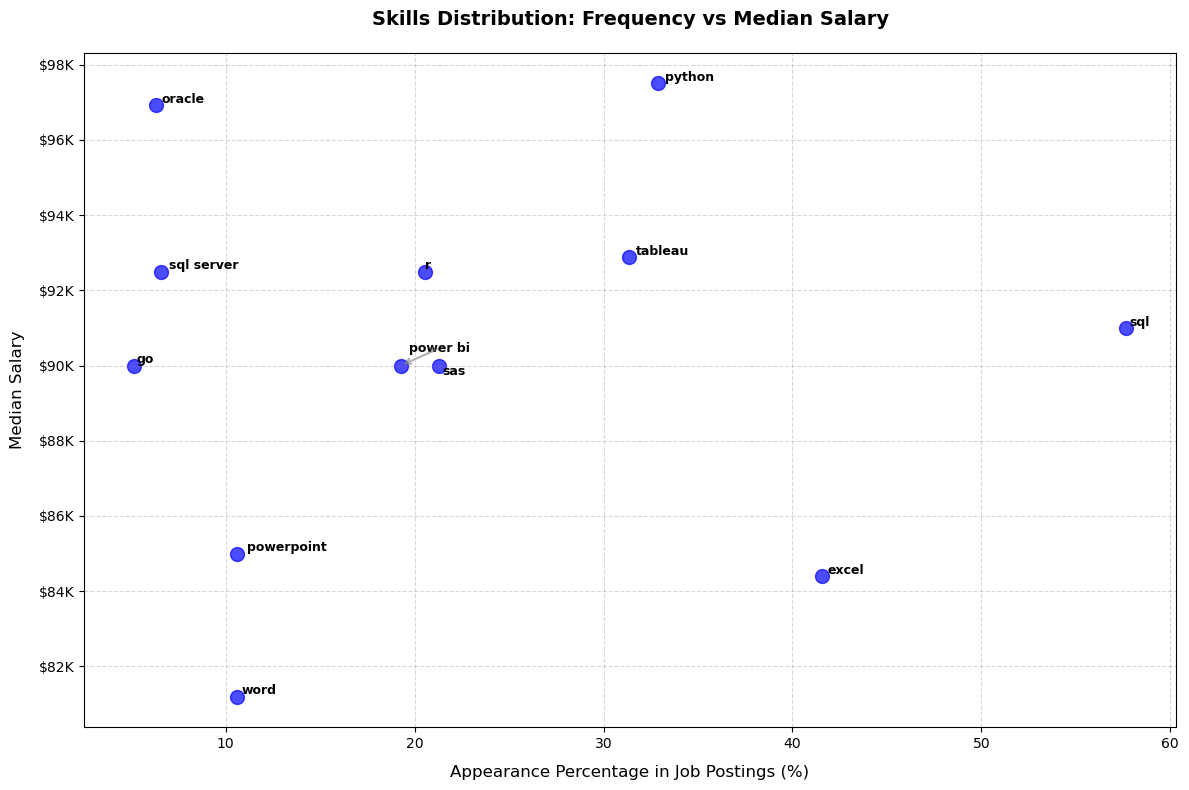

In [36]:
# Required import for adjustText
from adjustText import adjust_text

# Step 1: Explode the 'job_skills' column 
df_exploded = df_da_us.explode('job_skills')

# Step 2: Calculate skills_count and skills_percent
skills_summary = df_exploded['job_skills'].value_counts().reset_index()
skills_summary.columns = ['skills', 'skills_count']
skills_summary['skills_percent'] = (skills_summary['skills_count'] / len(df_da_us)) * 100

# Step 3: Calculate average and median salary for each skill
skills_salary = df_exploded.groupby('job_skills')['salary_year_avg'].agg(['mean', 'median']).reset_index()
skills_salary.columns = ['skills', 'avg_salary', 'median_salary']

# Step 4: Merge tables to include all information
skills_summary = pd.merge(skills_summary, skills_salary, on='skills')
skills_summary = skills_summary[skills_summary['skills_percent'] > 5]

# Step 5: Create the improved scatter plot
plt.figure(figsize=(12, 8))  # Increased size for better clarity

# Create scatter plot
plt.scatter(skills_summary['skills_percent'], 
            skills_summary['median_salary'], 
            alpha=0.7,
            color='blue',  # Add specific color
            s=100)  # Increase point size

# Prepare annotations with adjustText
texts = []
for i, row in skills_summary.iterrows():
    texts.append(plt.text(row['skills_percent'], 
                         row['median_salary'], 
                         row['skills'], 
                         fontsize=9,
                         fontweight='bold'))  # Bold text for better readability

# Automatically adjust text positions
adjust_text(texts,
            arrowprops=dict(arrowstyle='->',
                           color='gray',
                           lw=1.5,
                           alpha=0.6),
            expand_points=(1.5, 1.5),  # More space between points
            force_points=(0.1, 0.1))    # Repulsion force between points

# Customize style
plt.title('Skills Distribution: Frequency vs Median Salary', 
          fontsize=14, 
          pad=20,  # Extra space above title
          fontweight='bold')

plt.xlabel('Appearance Percentage in Job Postings (%)', 
          fontsize=12, 
          labelpad=10)  # Extra space below axis

plt.ylabel('Median Salary', 
          fontsize=12, 
          labelpad=10)

# Format salary axis
plt.gca().yaxis.set_major_formatter(lambda x, pos: '${:,.0f}K'.format(x/1000))

# Improve grid
plt.grid(True, linestyle='--', alpha=0.3, color='gray')

# Add border
plt.box(True)

# Adjust margins
plt.tight_layout()

# Display the plot
plt.show()

NOW LET'S COLOR CODE EACH SKILL BY THE SKILL TYPE OR TECHNOLOGY ASSOCIATED
-First, let's create a dictionnary which contains as keys the skills types and as values the types in a list
-Secondly, transform it into a dataframe, and explode the skills
-Then, merge it with the skils_summary dataframe, and do the plotting, by assigned the hue to the skills types

In [45]:
# Clean the job_type_skills column by converting string representations to dictionaries
df_da_us['job_type_skills'] = df_da_us['job_type_skills'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Create a dictionary to store skills by type
dict_skills = {}

# Iterate through each row in the DataFrame
for _, row in df_da_us.iterrows():
    job_type_skills = row['job_type_skills']
    
    # Skip rows with None job_type_skills
    if job_type_skills is not None:
        for skill_type, skills in job_type_skills.items():
            # Initialize a list for each skill type if it doesn't exist
            if skill_type not in dict_skills:
                dict_skills[skill_type] = []
            
            # Add unique skills for each skill type
            dict_skills[skill_type].extend([skill for skill in skills if skill not in dict_skills[skill_type]])

In [47]:
skills_summary

,skills,skills_count,skills_percent,avg_salary,median_salary
0,sql,2508,57.655172,97528.452231,91000.00
1,excel,1808,41.563218,87082.082312,84392.00
2,python,1431,32.896552,103378.401394,97500.00
3,tableau,1364,31.356322,99542.975824,92875.00
4,sas,926,21.287356,94204.301524,90000.00
5,r,893,20.528736,100207.429136,92500.00
6,power bi,838,19.264368,93093.142774,90000.00
7,powerpoint,462,10.620690,89234.860931,85000.00
8,word,461,10.597701,83448.896556,81194.75
9,sql server,286,6.574713,95218.238910,92500.00


In [49]:
# Step 1: Convert dictionary to dataframe and explode
df_skills_types = pd.DataFrame(list(dict_skills.items()), columns=['skill_type', 'skills'])
df_skills_types = df_skills_types.explode('skills')  # Explode the skill_type column
df_skills_types

,skill_type,skills
0,analyst_tools,alteryx
0,analyst_tools,tableau
0,analyst_tools,excel
0,analyst_tools,powerpoint
0,analyst_tools,word
...,...,...
9,sync,symphony
9,sync,unify
9,sync,webex
9,sync,wire


In [50]:
skills_summary_1 = skills_summary.copy()
skills_summary_1 = pd.merge(skills_summary_1, df_skills_types, on='skills')  # Merge with exploded skills types
skills_summary_1 = skills_summary_1[skills_summary_1['skills_percent'] > 5]
skills_summary_1

,skills,skills_count,skills_percent,avg_salary,median_salary,skill_type
0,sql,2508,57.655172,97528.452231,91000.00,programming
1,excel,1808,41.563218,87082.082312,84392.00,analyst_tools
2,python,1431,32.896552,103378.401394,97500.00,programming
3,tableau,1364,31.356322,99542.975824,92875.00,analyst_tools
4,sas,926,21.287356,94204.301524,90000.00,analyst_tools
5,sas,926,21.287356,94204.301524,90000.00,programming
6,r,893,20.528736,100207.429136,92500.00,programming
7,power bi,838,19.264368,93093.142774,90000.00,analyst_tools
8,powerpoint,462,10.620690,89234.860931,85000.00,analyst_tools
9,word,461,10.597701,83448.896556,81194.75,analyst_tools


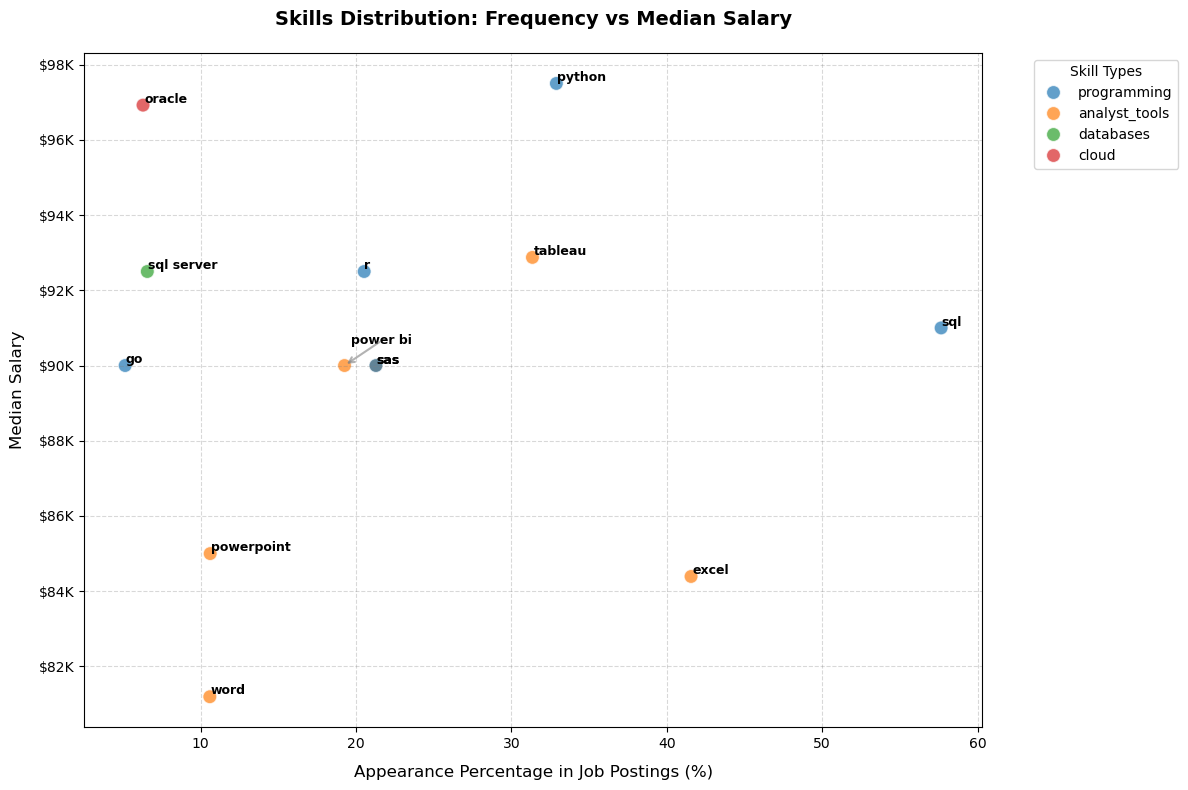

In [51]:
# Step 6: Create the improved scatter plot
plt.figure(figsize=(12, 8))

# Create scatter plot with seaborn
sns.scatterplot(data=skills_summary_1, 
                x='skills_percent', 
                y='median_salary',
                hue='skill_type',
                s=100,
                alpha=0.7)

# Prepare annotations with adjustText
texts = []
for i, row in skills_summary_1.iterrows():
    texts.append(plt.text(row['skills_percent'], 
                         row['median_salary'], 
                         row['skills'], 
                         fontsize=9,
                         fontweight='bold'))

# Automatically adjust text positions
adjust_text(texts,
            arrowprops=dict(arrowstyle='->',
                           color='gray',
                           lw=1.5,
                           alpha=0.6),
            expand_points=(1.5, 1.5),
            force_points=(0.1, 0.1))

# Customize style
plt.title('Skills Distribution: Frequency vs Median Salary', 
          fontsize=14, 
          pad=20,
          fontweight='bold')

plt.xlabel('Appearance Percentage in Job Postings (%)', 
          fontsize=12, 
          labelpad=10)

plt.ylabel('Median Salary', 
          fontsize=12, 
          labelpad=10)

# Format salary axis
plt.gca().yaxis.set_major_formatter(lambda x, pos: '${:,.0f}K'.format(x/1000))

# Improve grid
plt.grid(True, linestyle='--', alpha=0.3, color='gray')

# Move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Skill Types')

# Adjust margins
plt.tight_layout()

# Display the plot
plt.show()

In [35]:
skills_summary

,skills,skills_count,skills_percent,avg_salary,median_salary,skill_type
